This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import theano.tensor as tt
import scipy
import scipy.stats as stats
import seaborn as sns

import rasterio as rio
from rasterio import mask
import geopandas as gpd
from shapely.geometry import shape
import xarray as xr
import rioxarray
import fiona

import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from utils import *
tqdm.pandas()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Pre-Processing

In [4]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
                                          cols=['sewageSystem', 'ppt_2013', 'water_dist', 'gSSURGO_GA'],
                                          is_balanced=True)

balancing...
repairs: 11.054594777890811%, non-repairs: 88.94540522210919%
processing soil hydraulic data...
acquiring housing information...


# Topography

In [5]:
# open and clip DEM raster
dem = rioxarray.open_rasterio('../../Data/hydrosheds/hyd_na_dem_15s/hyd_na_dem_15s.tif')
ga_bdry = gpd.read_file('../../Data/ga_bdry')
ga_dem = dem.rio.clip(ga_bdry.geometry.values, ga_bdry.crs)
ga_dem = xr.where(ga_dem > 30000, 0, ga_dem)

In [6]:
# open and clip flow accumulation raster
flow = rioxarray.open_rasterio('../../Data/hydrosheds/na_acc_15s')
ga_bdry = gpd.read_file('../../Data/ga_bdry')
ga_flow = flow.rio.clip(ga_bdry.geometry.values, ga_bdry.crs)
ga_flow = xr.where(ga_flow < 0, 0, ga_flow)

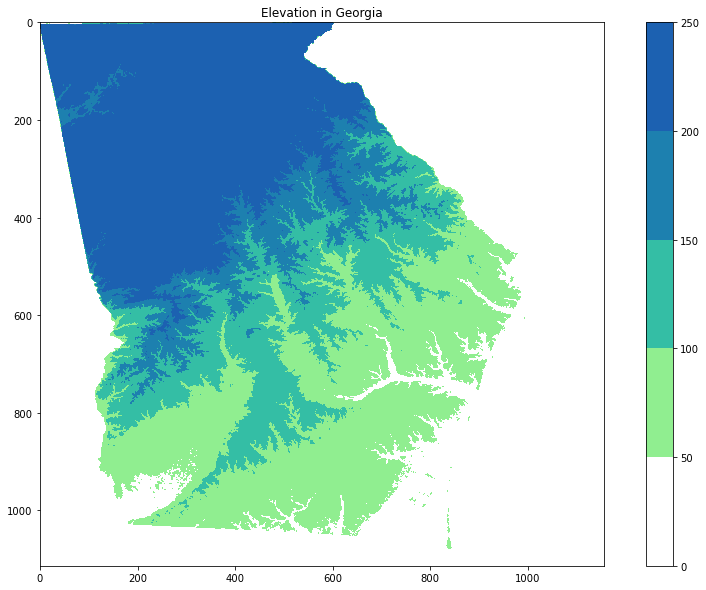

In [7]:
# plot DEM
cmap = colors.ListedColormap(['#ffffff', '#90ee90', '#34bea5', '#1d80af', '#1c61b1'])
bounds=[0, 50, 100, 150, 200, 250]
norm = colors.BoundaryNorm(bounds, cmap.N)

f, ax = plt.subplots(figsize=(15, 10))
bar = ax.imshow(ga_dem.squeeze(), cmap=cmap, norm=norm)
ax.set_title("Elevation in Georgia")
f.colorbar(bar)

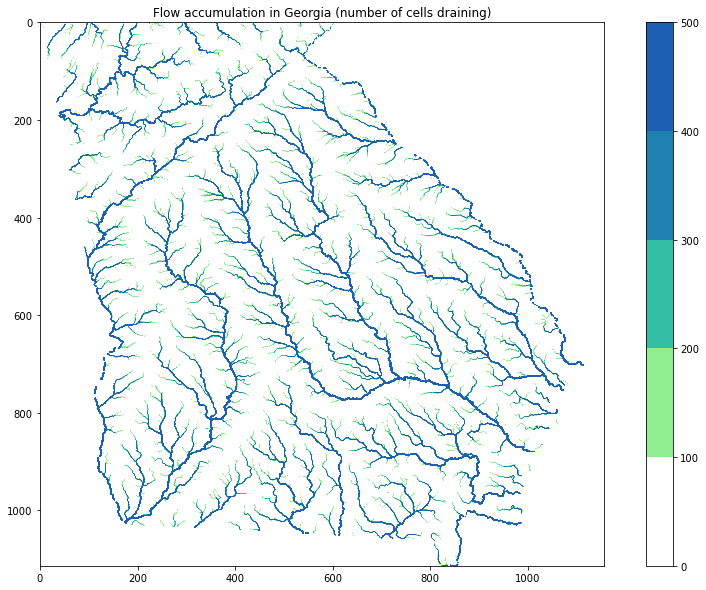

In [8]:
# plot flow accumulation
cmap = colors.ListedColormap(['#ffffff', '#90ee90', '#34bea5', '#1d80af', '#1c61b1'])
bounds=[0, 100, 200, 300, 400, 500]
norm = colors.BoundaryNorm(bounds, cmap.N)

f, ax = plt.subplots(figsize=(15, 10))
bar = ax.imshow(ga_flow.squeeze(), cmap=cmap, norm=norm)
ax.set_title("Flow accumulation in Georgia (number of cells draining)")
f.colorbar(bar)

In [9]:
# build spatial nearest neighbour lookup
kdtree_dem, dem_coords = build_kdtree(ga_dem)
kdtree_flow, flow_coords = build_kdtree(ga_flow)

In [10]:
def get_spatial_nearest(row, xa, kdtree, coords):
    pt = [row["tblSGA_Property.gis_long_property"], row["tblSGA_Property.gis_lat_property"]]
    dist, index = kdtree.query(pt)
    coor = coords[index]
    vals = xa.sel(x=coor[0], y=coor[1])
    return vals.item()

In [11]:
df['dem'] = df.apply(lambda x: get_spatial_nearest(x, xa=ga_dem, kdtree=kdtree_dem, coords=dem_coords), axis=1)
df = normalize(df, var='dem', var_norm='dem_norm')

df['flow'] = df.apply(lambda x: get_spatial_nearest(x, xa=ga_flow, kdtree=kdtree_flow, coords=flow_coords), axis=1)
df = normalize(df, var='flow', var_norm='flow_norm')

# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

## Empirical Distributions
Empirical analysis for 

1. distance to water bodies, precipitation: `01 hierarchical_bayesian_twovars`
2. soil hydraulic conductivity: `02 hierarchical_bayesian_threevars`
3. housing values: `03 hierarchical_bayesian_housing`

### a) Elevation

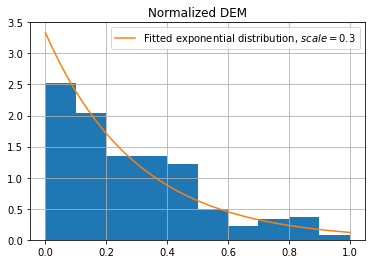

In [12]:
# plotting distribution (using Normal distribution)
x = np.linspace(0,1,100)
y = stats.gamma.pdf(x, a=1., scale=0.3)
df['dem_norm'].hist(density=True)
plt.plot(x,y, label="Fitted exponential distribution, $scale= 0.3$")
plt.title("Normalized DEM")
plt.legend()

### b) Flow accumulation

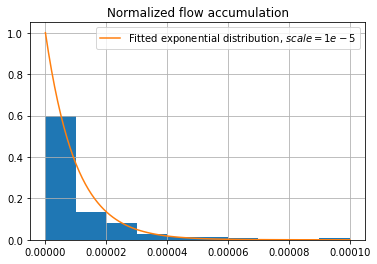

In [13]:
# plotting distribution (using Normal distribution)
x_max = 1e-4
x = np.linspace(0,x_max,100)
y = stats.gamma.pdf(x, a=1., scale=x_max * 0.1) * x_max * 0.1
df['flow_norm'].hist(range=[0., x_max], weights=np.ones_like(df['flow_norm']) / len(df['flow_norm']))
plt.plot(x,y, label="Fitted exponential distribution, $scale= 1e-5$")
plt.title("Normalized flow accumulation")
plt.legend()

The new variable, flow accumulation or DEM ($f$):

$$
\begin{align}
    \textbf{Flow or DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha = \alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1)\\
    \beta_f \sim HN_f(\sigma=5)\\
\end{align}
$$

The full hierarchical bayesian formula is as follows:
$$
\begin{align}
    Y_{k} \sim Bernoulli(\theta_{k})\\
    \theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k}.waterdist + \beta_{p,k}.precip + \beta_{h_k}.hydraulics + \beta_{v,k}.housing + \beta_{f,k}.flow)\\
    \textbf{Intercept parameters}\\
    \beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
    \mu_{0} \sim HN_0(\sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
    \textbf{Water distance parameters}\\
    \beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
    \alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=5)\\
    \textbf{Precipitation parameters}\\
    \beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
    \sigma_p \sim HN_p(\sigma=10)\\
    \textbf{Hydraulics parameters}\\
    \beta_{h,k} \sim U_{h,k}(lower=0,upper=\sigma_h)\\
    \sigma_h \sim HN_h(\sigma=10)\\
    \textbf{Housing parameters}\\
    \beta_{v,k} \sim HN_{v,k}(\sigma=\sigma_v)\\
    \sigma_v \sim HN_v(\sigma=10)\\
    \textbf{Flow/DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha=\alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1), \quad \beta_f \sim HN_f(\sigma=5)\\
    \text{the subscript $w$, $p$, $h$, and $v$ denote distance to water bodies, precipitation, hydraulics respectively, and housing value at the $k$-th basin}\\
    \text{$\sigma$ (inverse logistic) function returns the binary value of 0 (repair) or 1 (new/addition)}
\end{align}
$$

In [14]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    flow_d = pm.Data('flow_d', df.flow_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    wtr_alpha = pm.HalfNormal('wtr_alpha', sigma=1.)
    wtr_beta = pm.HalfNormal('wtr_beta', sigma=5)
    ppt_mu = pm.HalfNormal('ppt_mu', sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    flow_alpha = pm.HalfNormal('flow_alpha', sigma=1.)
    flow_beta = pm.HalfNormal('flow_beta', sigma=5)
    dem_alpha = pm.HalfNormal('dem_alpha', sigma=1.)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.HalfNormal('mu_c', sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Gamma('wtr_dist', alpha=wtr_alpha, beta=wtr_beta, dims='basin')
    ppt = pm.HalfNormal('ppt', sigma=ppt_sig, dims='basin')
    hydr = pm.Uniform('hydr', lower=0, upper=hydr_sig, dims='basin')
    hse = pm.HalfNormal('hse', sigma=hse_sig, dims='basin')
    flow = pm.Gamma('flow', alpha=flow_alpha, beta=flow_beta, dims='basin')
    dem = pm.Gamma('dem', alpha=dem_alpha, beta=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin_idx] 
                                    + wtr_dist[basin_idx] * water_d 
                                    + ppt[basin_idx] * ppt_d
                                    + hydr[basin_idx] * hydr_d
                                    + hse[basin_idx] * hse_d
                                    + flow[basin_idx] * flow_d
                                    + dem[basin_idx] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, flow, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, dem_beta, dem_alpha, flow_beta, flow_alpha, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 207 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'wtr_dist'}>,
        <AxesSubplot:title={'center':'wtr_dist'}>],
       [<AxesSubplot:title={'center':'ppt'}>,
        <AxesSubplot:title={'center':'ppt'}>],
       [<AxesSubplot:title={'center':'hydr'}>,
        <AxesSubplot:title={'center':'hydr'}>],
       [<AxesSubplot:title={'center':'hse'}>,
        <AxesSubplot:title={'center':'hse'}>],
       [<AxesSubplot:title={'center':'flow'}>,
        <AxesSubplot:title={'center':'flow'}>],
       [<AxesSubplot:title={'center':'dem'}>,
        <AxesSubplot:title={'center':'dem'}>]], dtype=object)

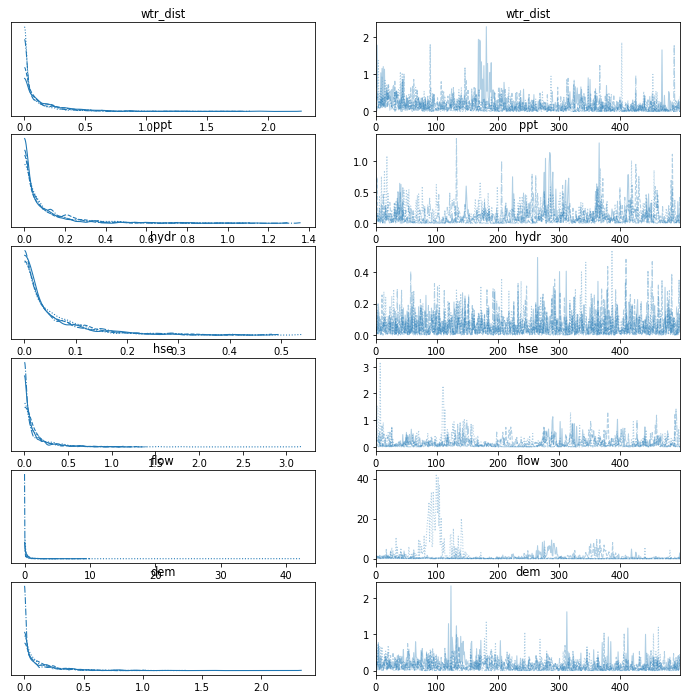

In [15]:
# get sample basin for analysis
sample_coords = {'basin': df.HU_12_NAME[:1].values}
var_names=['wtr_dist', 'ppt', 'hydr', 'hse', 'flow', 'dem']

# analyze the posterior distribution (fitted parameters)
az.plot_trace(trace, var_names=var_names, coords=sample_coords, figsize=(12,12), compact=True)

In [81]:
# evaluate model (just dem)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.33742331288343%


In [84]:
# evaluate model (just flow)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.1840490797546%


In [69]:
# evaluate model (both dem and flow)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.49079754601227%


# Evaluation

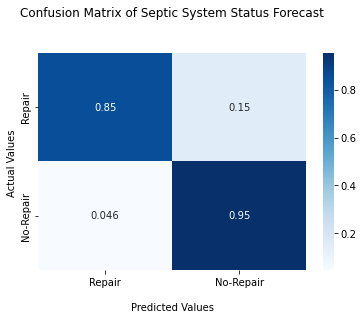

In [16]:
plot_confusion(y, y_pred)

array([[<AxesSubplot:title={'center':'wtr_dist\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'ppt\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'hydr\nWest Chickamauga Creek'}>],
       [<AxesSubplot:title={'center':'hse\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'flow\nWest Chickamauga Creek'}>,
        <AxesSubplot:>]], dtype=object)

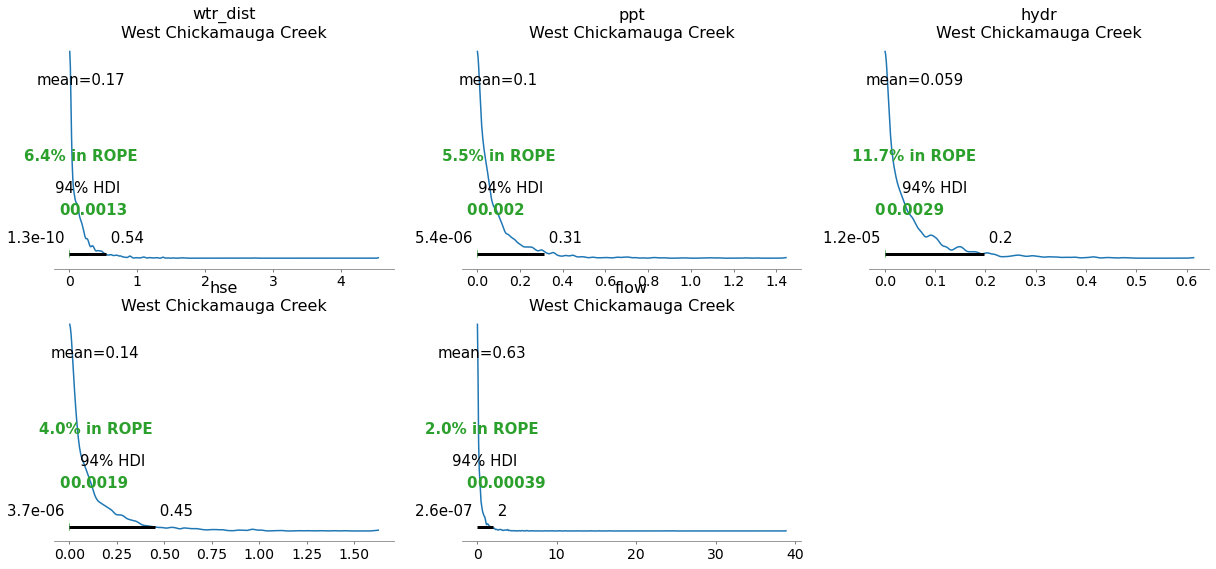

In [17]:
"""
posterior distribution with high density interval (HDI) and region of practical equivalence (ROPE)
analog of ROPE in frequentist statistics: null hypothesis (instead of point, in Bayesian we define a region)
region interval: [0, 0.01 * std] for normalized values according to Kruschke (2018)

"""
rope = {'wtr_dist': [{'rope': (0, df.water_dist_norm.values.std() * 0.01)}], 
        'ppt': [{'rope': (0, df.ppt_2013_norm.values.std() * 0.01)}],
        'hydr': [{'rope': (0, df.hydraulic_c_norm.values.std() * 0.01)}],
        'hse': [{'rope': (0, df.median_hse_norm.values.std() * 0.01)}],
        'flow': [{'rope': (0, df.flow_norm.values.std() * 0.01)}]
       }
az.plot_posterior(trace, coords=sample_coords, var_names=var_names, rope=rope)

# Baseline Comparison

In [28]:
train_x, test_x, train_y, test_y = train_test_split(df[['water_dist_norm', 'ppt_2013_norm', 'hydraulic_c_norm', 'median_hse_norm', 'flow_norm', 'dem_norm']], 
                                                    df['sewageSystem_enc'], 
                                                    test_size=0.1, 
                                                    random_state=42)

### a) Aggregate Bayesian

In [29]:
with pm.Model(coords=coords) as base_model:
    # constant data inputs
    basin = pm.Data('basin', basin_idx)
    water_d = pm.Data('water_d', train_x.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', train_x.ppt_2013_norm.values)
    hydr_d = pm.Data('hydr_d', train_x.hydraulic_c_norm.values)
    hse_d = pm.Data('hse_d', train_x.median_hse_norm.values)
    flow_d = pm.Data('flow_d', train_x.flow_norm.values)
    dem_d = pm.Data('dem_d', train_x.dem_norm.values)

    # global model priors
    wtr_alpha = pm.HalfNormal('wtr_alpha', sigma=1.)
    wtr_beta = pm.HalfNormal('wtr_beta', sigma=5)
    ppt_mu = pm.HalfNormal('ppt_mu', sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    flow_alpha = pm.HalfNormal('flow_alpha', sigma=1.)
    flow_beta = pm.HalfNormal('flow_beta', sigma=5)
    dem_alpha = pm.HalfNormal('dem_alpha', sigma=1.)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.HalfNormal('mu_c', sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # model parameters
    wtr_dist = pm.Gamma('wtr_dist', alpha=wtr_alpha, beta=wtr_beta)
    ppt = pm.HalfNormal('ppt', sigma=ppt_sig)
    hydr = pm.Uniform('hydr', lower=0, upper=hydr_sig)
    hse = pm.HalfNormal('hse', sigma=hse_sig)
    flow = pm.Gamma('flow', alpha=flow_alpha, beta=flow_beta)
    dem = pm.Gamma('dem', alpha=dem_alpha, beta=dem_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # complete bayesian formula
    failure_theta = pm.math.sigmoid(c 
                                    + wtr_dist * water_d 
                                    + ppt * ppt_d
                                    + hydr * hydr_d
                                    + hse * hse_d
                                    + flow * flow_d
                                    + dem * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=train_y)
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, flow, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, dem_beta, dem_alpha, flow_beta, flow_alpha, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [41]:
# evaluate baseline bayesian
pm.set_data({'water_d': test_x.water_dist_norm.values,
             'ppt_d': test_x.ppt_2013_norm.values,
             'hydr_d': test_x.hydraulic_c_norm.values,
             'hse_d': test_x.median_hse_norm.values,
             'flow_d': test_x.flow_norm.values,
             'dem_d': test_x.dem_norm.values
            }, model=base_model)

acc, y_pred = evaluate_bayes(trace, base_model, test_y)
print(f'accuracy is: {acc}%')

accuracy is: 53.03030303030303%


## Hyperparameter Optimization

In [103]:
# hyperparameter optimization with optuna
def objective(trial, classifier_name):
    assert classifier_name in ['SVC', 'RF']
    if classifier_name == 'SVC':
        svc_deg = trial.suggest_int('svc_deg', 1, 10)
        classifier_obj = SVC(C=svc_c, degree=svc_deg, gamma='auto')
        
    else:
        rf_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators)
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [95]:
# Optimize SVC
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='SVC'), n_trials=10)

[I 2022-04-19 22:32:54,956] A new study created in memory with name: no-name-07609984-a138-4529-a1d0-8122ef33cbbe
[I 2022-04-19 22:32:56,267] Trial 0 finished with value: 0.6176434676434676 and parameters: {'svc_c': 371.6029208635379, 'svc_deg': 6}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:32:56,788] Trial 1 finished with value: 0.5051194836909122 and parameters: {'svc_c': 5.211338796181748e-07, 'svc_deg': 6}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:32:57,302] Trial 2 finished with value: 0.5682626896912611 and parameters: {'svc_c': 2.6210694837658473, 'svc_deg': 5}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:33:15,861] Trial 3 finished with value: 0.6672422815279958 and parameters: {'svc_c': 2112343.8569213776, 'svc_deg': 7}. Best is trial 3 with value: 0.6672422815279958.
[I 2022-04-19 22:33:47,988] Trial 4 finished with value: 0.6774986917844061 and parameters: {'svc_c': 6864865.398448115, 'svc_deg': 9}. Best is 

[I 2022-04-19 22:52:27,754] Trial 41 finished with value: 0.6655416012558869 and parameters: {'svc_c': 7461422.694083228, 'svc_deg': 8}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:52:43,788] Trial 42 finished with value: 0.6723704866562009 and parameters: {'svc_c': 1718157.5496380676, 'svc_deg': 10}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:53:51,646] Trial 43 finished with value: 0.6552939124367696 and parameters: {'svc_c': 826471215.7204027, 'svc_deg': 9}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:54:36,520] Trial 44 finished with value: 0.6690040118611548 and parameters: {'svc_c': 19365340.440191716, 'svc_deg': 7}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:55:26,753] Trial 45 finished with value: 0.6758067329495901 and parameters: {'svc_c': 16080127.30509432, 'svc_deg': 8}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:55:26,811] Trial 46 finished with value: 0.624507238792

[I 2022-04-19 23:15:14,705] Trial 83 finished with value: 0.6416099773242631 and parameters: {'svc_c': 27702.864151351223, 'svc_deg': 4}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:17,230] Trial 84 finished with value: 0.6638060352346066 and parameters: {'svc_c': 229125.76444782582, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,319] Trial 85 finished with value: 0.6808826094540379 and parameters: {'svc_c': 785441.864486189, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,823] Trial 86 finished with value: 0.5051194836909122 and parameters: {'svc_c': 0.0007568020474464676, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,859] Trial 87 finished with value: 0.5051194836909122 and parameters: {'svc_c': 1.9988323331827892e-09, 'svc_deg': 1}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:53,311] Trial 88 finished with value: 0.

In [104]:
# Optimize RF
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='RF'), n_trials=100)

[I 2022-04-19 23:27:12,690] A new study created in memory with name: no-name-d2c58c0c-3d8e-4765-b55a-f4cec163a8c9
[I 2022-04-19 23:27:14,825] Trial 0 finished with value: 0.7543694400837259 and parameters: {'n_estimators': 616}. Best is trial 0 with value: 0.7543694400837259.
[I 2022-04-19 23:27:16,113] Trial 1 finished with value: 0.7560962846677133 and parameters: {'n_estimators': 570}. Best is trial 1 with value: 0.7560962846677133.
[I 2022-04-19 23:27:17,597] Trial 2 finished with value: 0.7560701203558345 and parameters: {'n_estimators': 719}. Best is trial 1 with value: 0.7560962846677133.
[I 2022-04-19 23:27:19,164] Trial 3 finished with value: 0.7663003663003662 and parameters: {'n_estimators': 787}. Best is trial 3 with value: 0.7663003663003662.
[I 2022-04-19 23:27:20,966] Trial 4 finished with value: 0.7543694400837259 and parameters: {'n_estimators': 975}. Best is trial 3 with value: 0.7663003663003662.
[I 2022-04-19 23:27:22,668] Trial 5 finished with value: 0.754369440083

[I 2022-04-19 23:27:57,876] Trial 46 finished with value: 0.7629077271934416 and parameters: {'n_estimators': 707}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:27:58,827] Trial 47 finished with value: 0.7628990057561486 and parameters: {'n_estimators': 719}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:27:59,709] Trial 48 finished with value: 0.7492673992673993 and parameters: {'n_estimators': 661}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:00,511] Trial 49 finished with value: 0.7526600383743242 and parameters: {'n_estimators': 618}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:01,553] Trial 50 finished with value: 0.7560788417931276 and parameters: {'n_estimators': 801}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:02,645] Trial 51 finished with value: 0.7509593581022153 and parameters: {'n_estimators': 859}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04

[I 2022-04-19 23:28:40,599] Trial 93 finished with value: 0.7509593581022153 and parameters: {'n_estimators': 850}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:41,541] Trial 94 finished with value: 0.750976800976801 and parameters: {'n_estimators': 714}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:42,735] Trial 95 finished with value: 0.7577882435025293 and parameters: {'n_estimators': 908}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:43,820] Trial 96 finished with value: 0.7560613989185417 and parameters: {'n_estimators': 829}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:44,602] Trial 97 finished with value: 0.7577795220652362 and parameters: {'n_estimators': 597}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:45,524] Trial 98 finished with value: 0.7577882435025293 and parameters: {'n_estimators': 681}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-

## Optimized Baseline Analysis

### b) Random Forest

accuracy for random forerst: 81.81818181818183%


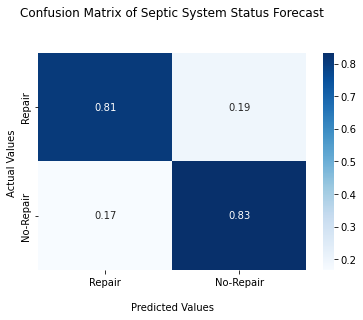

In [109]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=98)
rf_clf.fit(train_x, train_y)
rf_y_pred = rf_clf.predict(test_x)
acc = rf_clf.score(test_x, test_y)
print(f'accuracy for random forerst: {acc * 100}%')

plot_confusion(test_y, rf_y_pred)

### c) SVC

accuracy for SVC: 69.6969696969697%


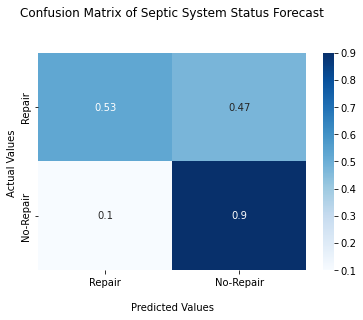

In [111]:
# SVC
svc_clf = SVC(degree= 3)
svc_clf.fit(train_x, train_y)
acc = svc_clf.score(test_x, test_y)
svc_y_pred = svc_clf.predict(test_x)
print(f'accuracy for SVC: {acc * 100}%')

plot_confusion(test_y, svc_y_pred)

# Archive

array([[<AxesSubplot:ylabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hydr\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hse\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='wtr_dist\nWest Chickamauga Creek', ylabel='flow\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='hydr\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='hse\nWest Chickamauga Creek'>]], dtype=object)

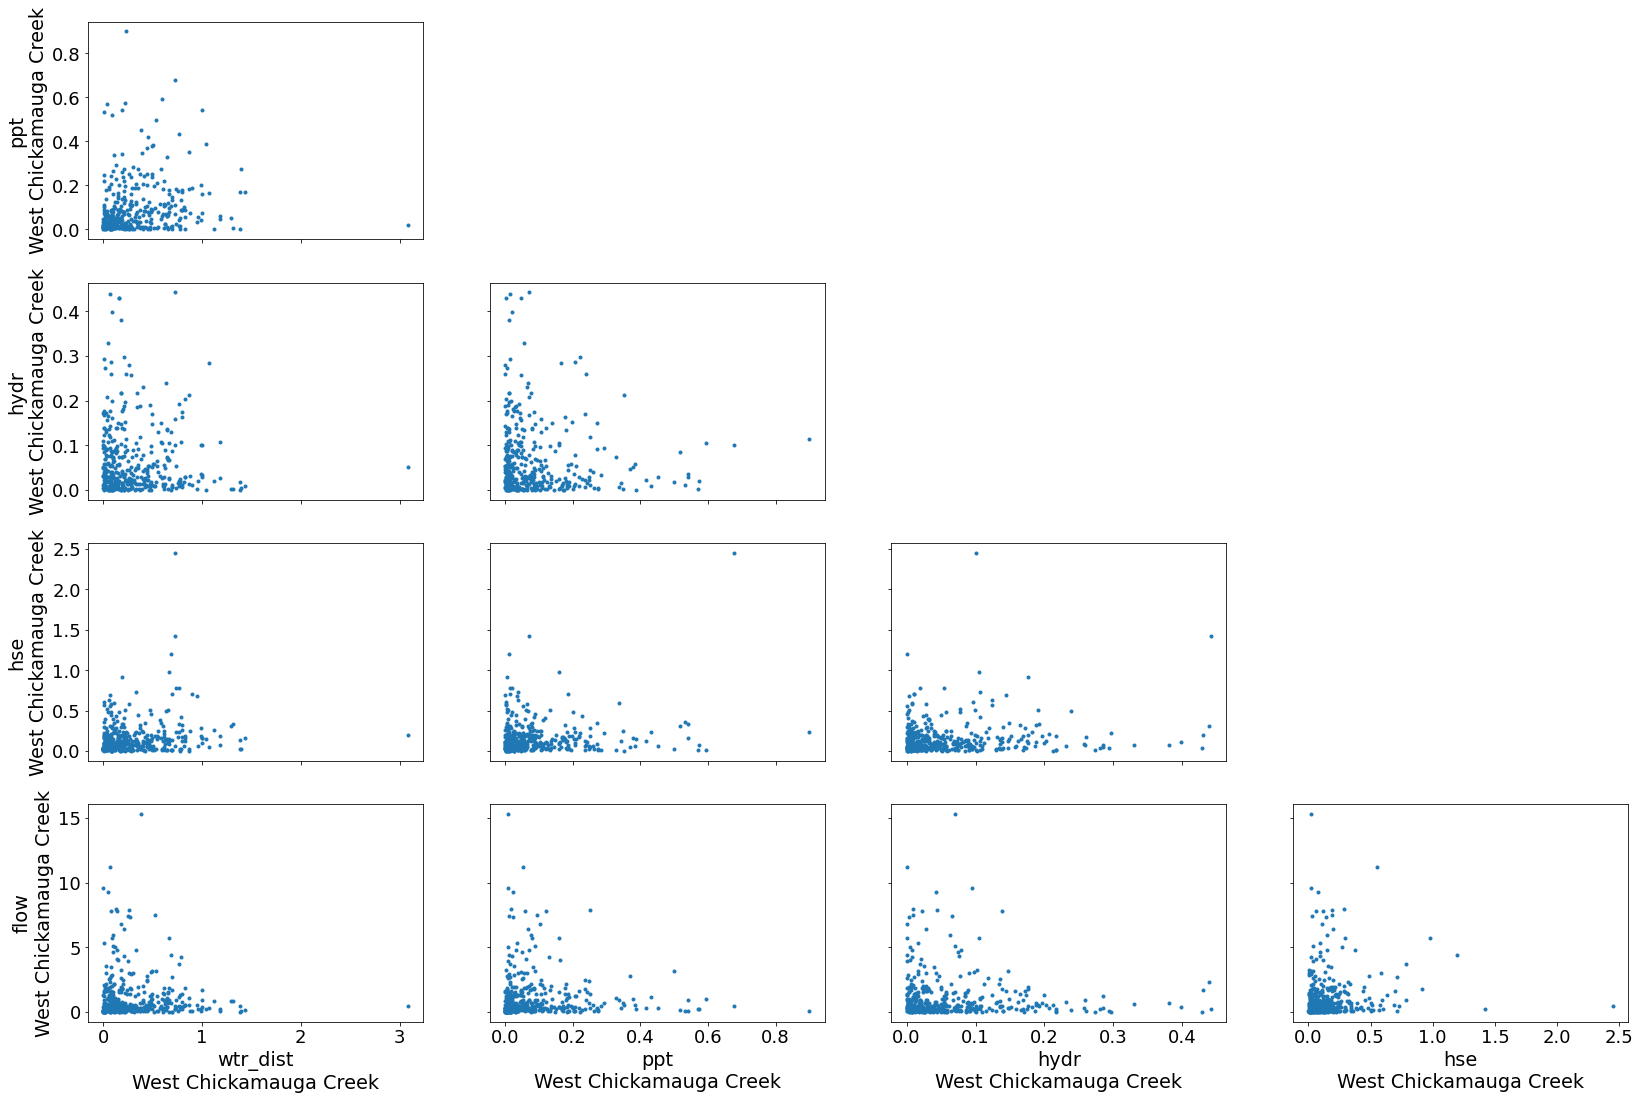

In [117]:
az.plot_pair(trace,
            var_names=var_names,
            coords=sample_coords,
            divergences=True,
            textsize=18)

In [118]:
print('correlation coefficient between:\n')
for var_a in var_names:
    for var_b in var_names:
        if var_a != var_b:
            var_a_ppc = trace.posterior[var_a][0,:,0].values
            var_b_ppc = trace.posterior[var_b][0,:,0].values
            m, c = np.polyfit(var_a_ppc,var_b_ppc,1)
            print(f"\t{var_a} and {var_b}: {m}")

correlation coefficient between:

	wtr_dist and ppt: 0.03370955103771865
	wtr_dist and hydr: -0.009107135142712382
	wtr_dist and hse: 0.030300248627335272
	wtr_dist and flow: -0.3071515321836366
	ppt and wtr_dist: 0.15470072444487332
	ppt and hydr: -0.007440801207459839
	ppt and hse: -0.071338362570054
	ppt and flow: -0.4802597140235286
	hydr and wtr_dist: -0.1386576831526813
	hydr and ppt: -0.024685531411005192
	hydr and hse: -0.022840155111263652
	hydr and flow: 0.43745664155762043
	hse and wtr_dist: 0.12631873717471204
	hse and ppt: -0.06480452637360895
	hse and hydr: -0.006254008600319234
	hse and flow: 0.2329962306001464
	flow and wtr_dist: -0.07224201076384736
	flow and ppt: -0.024613530843266663
	flow and hydr: 0.006757872533039219
	flow and hse: 0.013145116858790266
